In [2]:
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem as ch
from rdkit.Chem import Draw as d
from rdkit import DataStructs
import pandas as pd
from rdkit.Chem import rdMolDescriptors as rdescriptors
from matplotlib.mlab import PCA
import matplotlib.pyplot as plt
import csv
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

import sklearn
from rdkit.Chem import PandasTools, Descriptors, MolFromSmiles
from pandas import DataFrame
from sklearn.model_selection import train_test_split

from sklearn import svm
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
with open ('bioac.csv', 'r') as f:
    conntent = list((csv.reader(f, delimiter = '\t')))


In [4]:
names = []

for i in range(1,len(conntent)):
    m = conntent[i][0]
    names.append(m)

In [5]:
smiles = []
for i in range(1,len(conntent)):
    m = conntent[i][1]
    smiles.append(m)

In [6]:
mols = []

for i in range(1,len(conntent)):
    m = ch.MolFromSmiles(conntent[i][1])
    mols.append(m)

In [7]:
activity = []

for i in range(1,len(conntent)):
    m = conntent[i][3]
    activity.append(m)

In [8]:
def num_hydrogen_bond_acceptors(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol)

In [9]:
def num_hydrogen_bond_donors(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol)

In [10]:
def MW(mol):
    return Descriptors.MolWt(mol)

In [11]:
def TPSA(mol):
    return Descriptors.TPSA(mol)

In [12]:
def logP(mol):
    return Descriptors.MolLogP(mol)

In [13]:
data=[]
for i,mol in enumerate(mols):
    data.append([names[i], float(activity[i]), num_hydrogen_bond_acceptors(mol), num_hydrogen_bond_donors(mol), MW(mol), logP(mol),TPSA(mol)])

In [ ]:
###############PCA#######################################################

In [14]:
dataframe=pd.DataFrame(data,columns=["CHEMBL_ID", "activity", "HBA", "HBD", "MW", "logP", "TPSA"])
dataframe.set_index("CHEMBL_ID",inplace=True)

In [15]:
pca1=PCA(dataframe)

In [16]:
plt.rcParams["figure.figsize"] = [10, 10]
#fig = plt.figure()
X = [x[0] for x in pca1.Y]
Y = [y[1] for y in pca1.Y]
plt.scatter(X,Y)
labels = zip(names, X,Y)
for l in labels:
    if l[1]<-3:
        plt.annotate(l[0], (l[1], l[2]))

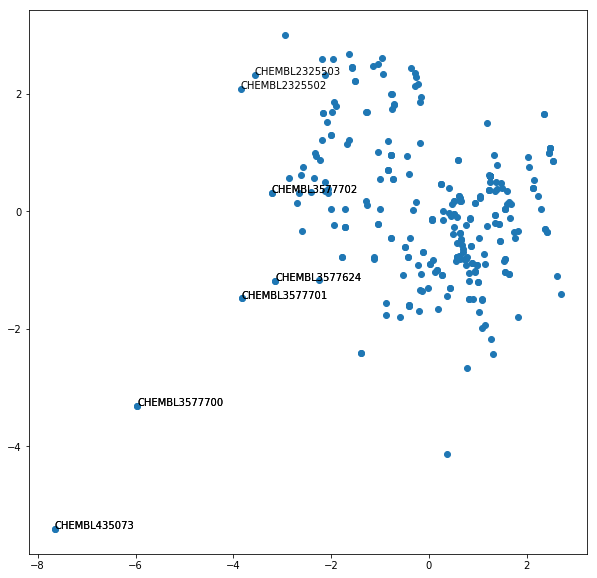

In [17]:
plt.show()

In [ ]:
#######################CLUSTER###########################################

In [18]:
id = list(range(len(conntent)))

In [19]:
mols_fps = [(m, ch.GetMorganFingerprint(m,2)) for m in mols]

In [20]:
def fp_distance(i,j,mols_fps=mols_fps):
    return 1 - DataStructs.TanimotoSimilarity(mols_fps[i][1],mols_fps[j][1])

In [21]:
picker = MaxMinPicker()

In [22]:
pickIndices = picker.LazyPick(fp_distance, len(mols_fps), 200, seed=42)

In [23]:
picked = [mols[i] for i in pickIndices] 

In [24]:
data=[]
for i,mol in enumerate(picked):
    data.append([names[i],activity[i], num_hydrogen_bond_acceptors(mol), num_hydrogen_bond_donors(mol), MW(mol), logP(mol),TPSA(mol)])

In [43]:
j=0
out = open("input_file.csv", "w")
out.write("ID,CHEMBL_ID,HBA,HBD,MW,logP,TPSA\n")
        
for i in range(0,len(data)):
    out.write('molekula_id'+str(id[i]) + ','+ str(data[i][j+2]) + ',' + str(data[i][j+3]) + ','
              + str(data[i][j+4]) + ',' + str(data[i][j+5]) + ',' + str(data[i][j+6]) + '\n')
    
out.close()

In [44]:

out = open("lipinski_metadata2.csv", "w")
out.write("ID,activity\n")
        
for i in range(0,len(data)):
    out.write('molekula_id'+str(id[i]) + ',' + str(activity[i]) + '\n')
    
out.close()

In [45]:
for i in range(len(mols)):
    d.MolToFile(mols[i], "molekula_id" +str(id[i])+ ".png")

In [ ]:
#######################PRED_ACTIVITY################################

In [26]:
id = list(range(len(conntent)))

In [27]:
data2 = []
for i in range(len(conntent)-1):
    data2.append([id[i], smiles[i], float(activity[i])])

In [28]:
data2[:5]

[[0,
  'O=C(CCSC1=NC2=C(CCCC2)C(=O)N1)N[C@@H]3CC[C@H](CC3)c4oc(nn4)c5ccccc5',
  2.5],
 [1, 'Oc1nc(nc2CCSCc12)c3ccc(cc3)C(F)(F)F', 4.0],
 [2, 'Oc1nc(nc2CCSCc12)c3ccc(cc3)C(F)(F)F', 5.0],
 [3, 'O=C(CCC1CCCCC1)Nc2nnc3SCCn23', 8.0],
 [4, 'Fc1ccc(cc1)C(=O)C2CCN(CC(=O)N(CC3CC3)CC4=NC5=C(COCC5)C(=O)N4)CC2', 11.0]]

In [29]:
data3 = DataFrame(data2, columns=["id","smi","ic50"]) 
data3.set_index("id", inplace=True)

In [30]:
desc_list = Descriptors.descList

In [31]:
data3["pic50"] = data3.ic50.apply(lambda x : -1.0 * np.log10(x / 1.0e9))#novy sloupec s zaporne dek IC50
for desc_name, function in desc_list:
    values = []
    for smiles in data3["smi"]:
        mol = MolFromSmiles(smiles)
        values.append(function(mol))
    data3[desc_name] = values

In [32]:
columns = [x[0] for x in desc_list[:30]] #pouze 30, omezit

In [33]:
train_data, test_data = train_test_split(data3)

In [34]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor()
model2.fit(train_data[columns], train_data["pic50"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

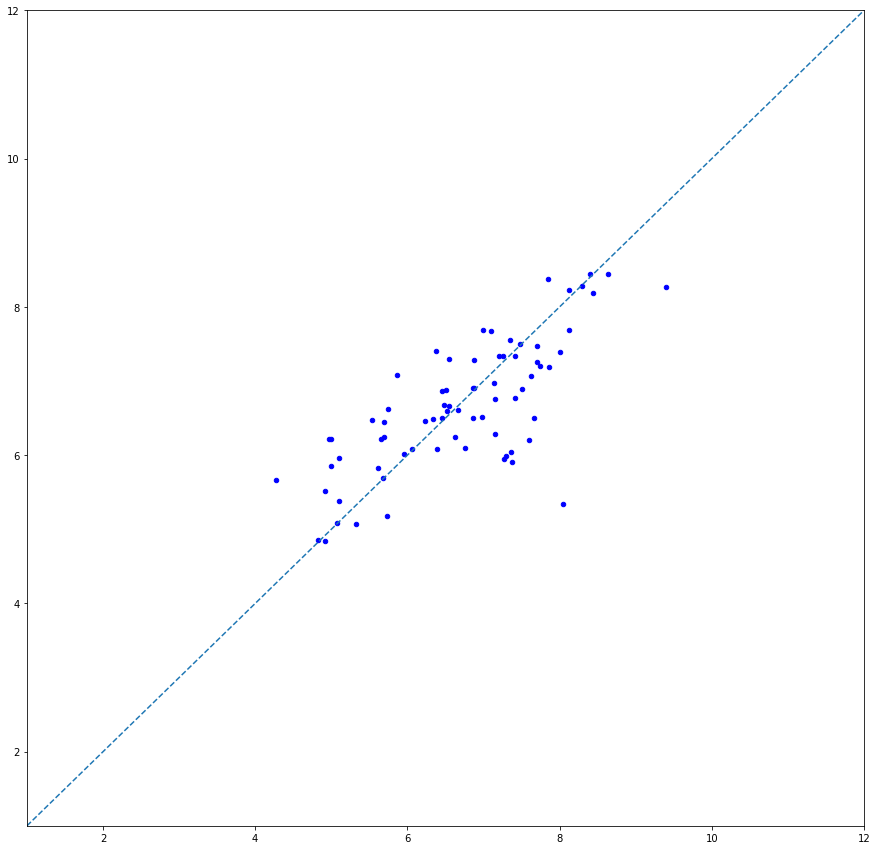

In [35]:
plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

#graficky overit
plt.scatter(
    test_data["pic50"]
    , model2.predict(test_data[columns])
    , c='blue'
    , s=20
)
plt.show()

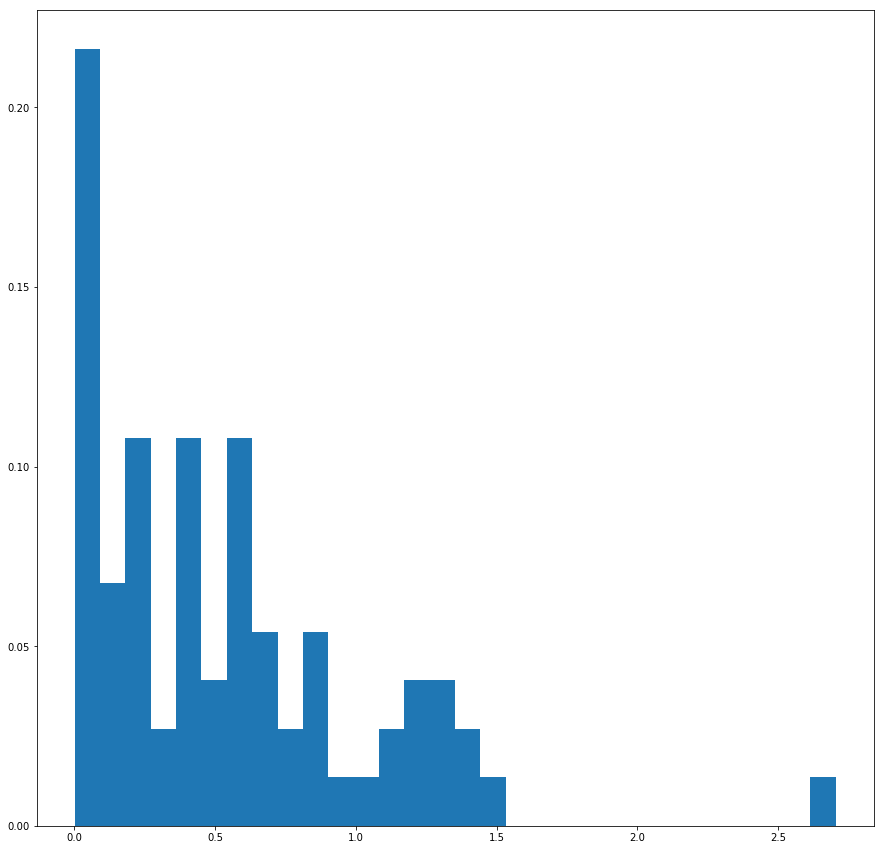

In [36]:
errors = (test_data.pic50 - model2.predict(test_data[columns])).abs()
weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights, bins=30)
plt.show()

In [37]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

def scale_df(frame, scaler):
    return DataFrame(scaler.transform(frame), columns=frame.columns)

scaler = StandardScaler(copy=False)
scaler.fit(concat( (train_data.iloc[:,3:], test_data.iloc[:,3:]) ))

descriptors_train = scale_df(train_data.iloc[:,3:], scaler)
descriptors_train.index = train_data.index
descriptors_test = scale_df(test_data.iloc[:,3:], scaler)
descriptors_test.index = test_data.index
print(descriptors_train.shape, descriptors_test.shape)
descriptors_train.head()

(220, 196) (74, 196)


,MaxEStateIndex,MinAbsEStateIndex,MinPartialCharge,MinAbsPartialCharge,MolWt,NumValenceElectrons,MaxAbsPartialCharge,MaxPartialCharge,MinEStateIndex,MaxAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
id,,,,,,,,,,,,,,,,,,,,,
272,0.165183,-0.715860,0.502416,-0.182170,-0.735797,-0.586405,-0.553927,-0.218696,0.338907,0.165183,...,-0.632456,0.0,-0.117444,0.0,0.0,0.0,0.0,-0.27735,-0.101535,-0.231869
113,-3.150479,2.873322,-1.246391,-0.516643,1.362647,1.257795,1.211976,-0.511787,0.814913,-3.150479,...,1.581139,0.0,-0.117444,0.0,0.0,0.0,0.0,-0.27735,-0.101535,-0.231869
132,0.190776,-0.693112,0.502416,-0.182170,-0.580221,-0.407934,-0.553927,-0.218696,0.330537,0.190776,...,-0.632456,0.0,-0.117444,0.0,0.0,0.0,0.0,-0.27735,-0.101535,-0.231869
85,0.778277,-0.744148,-1.246415,-0.153805,1.795747,2.090660,1.212000,-0.193840,0.337883,0.778277,...,-0.632456,0.0,-0.117444,0.0,0.0,0.0,0.0,-0.27735,-0.101535,-0.231869
82,0.113089,-0.212834,0.699506,-0.151109,-1.035991,-0.943347,-0.752944,-0.191478,0.299430,0.113089,...,-0.632456,0.0,-0.117444,0.0,0.0,0.0,0.0,-0.27735,-0.101535,-0.231869
